## Data Ingestion

In [1]:
# import sys
# !conda install --yes --prefix {sys.prefix} pycoingecko

In [2]:
from datetime import datetime
from datetime import date
import time
import json
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

# import API
from pycoingecko import CoinGeckoAPI

#import py scripts
import sandinfo as si

# pandas options
pd.options.display.float_format = '{:,.2f}'.format
pd.options.mode.chained_assignment = None

# USE CAUTION/UNCOMMENT if necessary
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 30)
# pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 150)

# plotting
%matplotlib inline

# Constants:
SAND_PRICE_IN_USD = 7.23
SAND_PRICE_DATETIME = '2021-11-24'

# Initial dataframe is the top-level, need to flatten
df_initial = pd.read_json('top_wallets_and_transactions_with_USD_prices_and_tags.json')
display(df_initial.head())
print(df_initial.shape)
print(df_initial.columns)

,holders
0,"{'address': '0x2f2456953a2cbc21fde058d33fb2ad8d59e72a35', 'tag': 'Smart Contract', 'balance': 1108241744.15, 'share': 36.94, 'transactions': [{'ti..."
1,"{'address': '0x5f5b8942ae6325227d5d82e5759e837271fa2a67', 'tag': 'Smart Contract', 'balance': 522999999.99999994, 'share': 17.43, 'transactions': ..."
2,"{'address': '0x8ffa64fb50559c3ff09a1022b84b2c5233ed8068', 'tag': 'Smart Contract', 'balance': 281512136.62667745, 'share': 9.38, 'transactions': [..."
3,"{'address': '0xf977814e90da44bfa03b6295a0616a897441acec', 'tag': 'Binance 8', 'balance': 261899174.6018669, 'share': 8.73, 'transactions': [{'time..."
4,"{'address': '0x07d2601739709c25fe0afd50ec961ba589311caa', 'tag': 'Smart Contract', 'balance': 195000000.0, 'share': 6.5, 'transactions': [{'timest..."


(200, 1)
Index(['holders'], dtype='object')


In [3]:
def flat_sand_data():
    """Flatten JSON object to derive transaction level data."""
    with open('top_wallets_and_transactions_with_USD_prices_and_tags.json','r') as json_file:
        json_data = json.load(json_file)
        df = pd.json_normalize(
            json_data,
            record_path=["holders","transactions"],
            sep="_",
            meta=[
                     ['holders','address'],
                     ['holders','balance'],
                     ['holders','share'],
                     ['holders','tag']
            ],
            errors='ignore'
        )
        df = df.rename(
            columns={
                'type': 'tx_type',
                'from': 'address_from',
                'to': 'address_to',
                'value': 'abs_value'
            }
        )
        
        df = df.reindex(
            columns = [
                'holders_address',
                'holders_balance', 
                'holders_share',
                'holders_tag',
                'transactionHash',
                'timestamp',
                'tx_type',
                'address_from',
                'address_to',
                'abs_value',
                'USD_price_at_timestamp',
            ]
        )
        
    return df

df_flat = flat_sand_data()
df_flat


,holders_address,holders_balance,holders_share,holders_tag,transactionHash,timestamp,tx_type,address_from,address_to,abs_value,USD_price_at_timestamp
0,0x2f2456953a2cbc21fde058d33fb2ad8d59e72a35,"1,108,241,744.15",36.94,Smart Contract,0x50487f46f22f02c0bfae873f28065bd30ec9f904911f905287a1cd04a2dedbdd,1630991473,transfer,0x2f2456953a2cbc21fde058d33fb2ad8d59e72a35,0x2396c520895ddb998c48acce50a5f6de33ecc5f9,"6,000,000.00",0.87
1,0x2f2456953a2cbc21fde058d33fb2ad8d59e72a35,"1,108,241,744.15",36.94,Smart Contract,0xe1f1657df50ebb6b74f38d06570bd28ae5861efb3b19451f083fabad44a5bd3f,1630621330,transfer,0x2f2456953a2cbc21fde058d33fb2ad8d59e72a35,0x2f8c8e82185c831ea96c02edda9dfac941ac98e3,"806,182.00",1.01
2,0x2f2456953a2cbc21fde058d33fb2ad8d59e72a35,"1,108,241,744.15",36.94,Smart Contract,0x5f5c489f9255598d4422114b2a7002de8d71995c61621e47c6a15b5569fbe68a,1629307800,transfer,0x2f2456953a2cbc21fde058d33fb2ad8d59e72a35,0xac8eb5574c9c706f5293a247bdb5d667e87a0599,"1,388,889.00",0.59
3,0x2f2456953a2cbc21fde058d33fb2ad8d59e72a35,"1,108,241,744.15",36.94,Smart Contract,0x2dd8630d7cf54ea63a9adccca0d8a44d4c35fa0c01185733c59ab6f0dbdcfb29,1629264914,transfer,0x2f2456953a2cbc21fde058d33fb2ad8d59e72a35,0xdf89c888c802eafaad084e9b1d5298409888ee3f,"1,122,094.00",0.59
4,0x2f2456953a2cbc21fde058d33fb2ad8d59e72a35,"1,108,241,744.15",36.94,Smart Contract,0x80421643f22411b2322e5927636a6e600f90decc2acbda7714129caaa7095ff9,1629205903,transfer,0x2f2456953a2cbc21fde058d33fb2ad8d59e72a35,0xc34003b336899ece931075c580a2b45b8c3a4f72,"336,628.00",0.64
...,...,...,...,...,...,...,...,...,...,...,...
18134,0x50fc70265a5bf285d8644628efa5a4fb96d6b7cf,"149,945.00",0,NaN,0x00d9fe7bed060dd2dea6638328d31cf4d994d1dc7c37607975d1f40f6f4b6cec,1636064352,transfer,0x23b260bc98dcd69f9b572dad2c4823489610c19f,0x50fc70265a5bf285d8644628efa5a4fb96d6b7cf,"300,000.00",2.65
18135,0x50fc70265a5bf285d8644628efa5a4fb96d6b7cf,"149,945.00",0,NaN,0x5e13d97ae1900cf9b14986690bdf415ff7d78f5d261f6aad05e33e201f639ef2,1636041663,transfer,0x50fc70265a5bf285d8644628efa5a4fb96d6b7cf,0x28c6c06298d514db089934071355e5743bf21d60,"200,000.00",2.77
18136,0x50fc70265a5bf285d8644628efa5a4fb96d6b7cf,"149,945.00",0,NaN,0x513b666d64d5b359e998bab9923bf7267b60af53ab72705ef39384c452fb3212,1636020272,transfer,0x23b260bc98dcd69f9b572dad2c4823489610c19f,0x50fc70265a5bf285d8644628efa5a4fb96d6b7cf,"200,000.00",3.01
18137,0x50fc70265a5bf285d8644628efa5a4fb96d6b7cf,"149,945.00",0,NaN,0x2aeda1ab69628624526b5644fe4ffdae30dac120822b1b62e008900c9a94c594,1635462175,transfer,0x50fc70265a5bf285d8644628efa5a4fb96d6b7cf,0x28c6c06298d514db089934071355e5743bf21d60,"100,000.84",0.92


In [4]:
# List of unique "tags". Wallets are "tagged" to denote a Smart Contract or belonging to a centralized exchange.
# For the purposes of this study in which we are assessing the investment activity performance, we are excluding tagged wallets.

df_flat['holders_tag'].unique()

array(['Smart Contract', 'Binance 8', nan, 'Binance 14',
       'Smart Contract - Gemini 6', 'KuCoin 6', 'Huobi 10', 'OKEx',
       'Crypto.com', 'FTX Exchange', 'Smart Contract - Gemini 4',
       'Binance', 'Smart Contract - Uniswap V2: SAND 24', 'Binance 15',
       'Smart Contract - Bitstamp 2', 'Gate.io', 'Binance 16', 'Bittrex',
       'Gate.io 3', 'Smart Contract - Index Coop: Metaverse Index',
       'Coinone', 'Poloniex 4', 'KuCoin 3', 'MXC 2',
       'Smart Contract - Uniswap V2: SAND-REVV', 'MXC',
       'Smart Contract - Wormhole: Token Bridge', 'Indodax 2',
       'BitMart 2', 'OpenSea: Wallet',
       'Smart Contract - Uniswap V3: SAND',
       'Smart Contract - MEV Bot: 0x4d2...2d3', 'Coinex',
       'Smart Contract - PieDAO: PLAY Token', 'Bitlo Hot Wallet 1',
       'Smart Contract - Coinhako: Warm Wallet', 'ioi.eth'], dtype=object)

In [5]:
# df_no_tag filters out the all transactions with holders that are "tagged".

df_no_tag = df_flat[df_flat['holders_tag'].isnull()]
df_no_tag

,holders_address,holders_balance,holders_share,holders_tag,transactionHash,timestamp,tx_type,address_from,address_to,abs_value,USD_price_at_timestamp
297,0x0404d96d2583799bc73edb8d230aa037fc22b379,"110,480,542.03",3.68,NaN,0xf6aa52272a0c657bfba0b0a9efc2c1a8a578cca48683c2bf464b24fc6157b28d,1637770791,transfer,0x0404d96d2583799bc73edb8d230aa037fc22b379,0x4ec320bbcd6a28c8dbac21fdec41ce2e7f2b08ed,"6,500,000.00",7.39
298,0x0404d96d2583799bc73edb8d230aa037fc22b379,"110,480,542.03",3.68,NaN,0x52014e11bc58de64c9fec02653f6d332daf0f1efbc9a93762080bd18828d995d,1637694437,transfer,0x1938a448d105d26c40a52a1bfe99b8ca7a745ad0,0x0404d96d2583799bc73edb8d230aa037fc22b379,"22,311.96",5.44
299,0x0404d96d2583799bc73edb8d230aa037fc22b379,"110,480,542.03",3.68,NaN,0xdc2710f9dae75805e0d0726562bd9d16a1d2ae38aeb46f5306498f9171f9a349,1637694246,transfer,0x1938a448d105d26c40a52a1bfe99b8ca7a745ad0,0x0404d96d2583799bc73edb8d230aa037fc22b379,"9,396.47",5.50
300,0x0404d96d2583799bc73edb8d230aa037fc22b379,"110,480,542.03",3.68,NaN,0x10740c765d585d9e5445bccf122e158dd676adc8412813b4ee9e3e05e08a2d8a,1637685721,transfer,0x1938a448d105d26c40a52a1bfe99b8ca7a745ad0,0x0404d96d2583799bc73edb8d230aa037fc22b379,"48,379.05",5.19
301,0x0404d96d2583799bc73edb8d230aa037fc22b379,"110,480,542.03",3.68,NaN,0xeae21f50c16eed90d85b63f29a92192eb6d9e93274d9cbba685cbeb2ddecbcb2,1637685537,transfer,0x1938a448d105d26c40a52a1bfe99b8ca7a745ad0,0x0404d96d2583799bc73edb8d230aa037fc22b379,"1,190,689.03",5.20
...,...,...,...,...,...,...,...,...,...,...,...
18134,0x50fc70265a5bf285d8644628efa5a4fb96d6b7cf,"149,945.00",0,NaN,0x00d9fe7bed060dd2dea6638328d31cf4d994d1dc7c37607975d1f40f6f4b6cec,1636064352,transfer,0x23b260bc98dcd69f9b572dad2c4823489610c19f,0x50fc70265a5bf285d8644628efa5a4fb96d6b7cf,"300,000.00",2.65
18135,0x50fc70265a5bf285d8644628efa5a4fb96d6b7cf,"149,945.00",0,NaN,0x5e13d97ae1900cf9b14986690bdf415ff7d78f5d261f6aad05e33e201f639ef2,1636041663,transfer,0x50fc70265a5bf285d8644628efa5a4fb96d6b7cf,0x28c6c06298d514db089934071355e5743bf21d60,"200,000.00",2.77
18136,0x50fc70265a5bf285d8644628efa5a4fb96d6b7cf,"149,945.00",0,NaN,0x513b666d64d5b359e998bab9923bf7267b60af53ab72705ef39384c452fb3212,1636020272,transfer,0x23b260bc98dcd69f9b572dad2c4823489610c19f,0x50fc70265a5bf285d8644628efa5a4fb96d6b7cf,"200,000.00",3.01
18137,0x50fc70265a5bf285d8644628efa5a4fb96d6b7cf,"149,945.00",0,NaN,0x2aeda1ab69628624526b5644fe4ffdae30dac120822b1b62e008900c9a94c594,1635462175,transfer,0x50fc70265a5bf285d8644628efa5a4fb96d6b7cf,0x28c6c06298d514db089934071355e5743bf21d60,"100,000.84",0.92


## Most frequent From and To Wallet Addresses:

In [6]:
display(df_no_tag['address_from'].value_counts())
display(df_no_tag['address_to'].value_counts())

0x1938a448d105d26c40a52a1bfe99b8ca7a745ad0    1574
0xc1ff7cea93d2324a76e1cb19c98d5e0a3a2b6b3f     983
0x3dd49f67e9d5bc4c5e6634b3f70bfd9dc1b6bd74     613
0x4da0eda15a164e78fddc0eddbee9295a78aa230e     503
0x24b4eae904632c53ee231e3bd6c4444745ce22c0     492
                                              ... 
0xa38f0b739d2bf66c71445e7f7da5634582133c83       1
0x265334f9cbaf37efa79ced7169fd09da3528aa78       1
0x1522900b6dafac587d499a862861c0869be6e428       1
0x200555d78d2ab0797caef8e2a6a10956b67d8fc3       1
0x7d8e112d858feec0a95e31177597a909e14be924       1
Name: address_from, Length: 746, dtype: int64

0x0404d96d2583799bc73edb8d230aa037fc22b379    908
0x08f14cfcc8f0b67bfac70d3f93623775577e0909    638
0x3dd49f67e9d5bc4c5e6634b3f70bfd9dc1b6bd74    558
0x24b4eae904632c53ee231e3bd6c4444745ce22c0    509
0x4da0eda15a164e78fddc0eddbee9295a78aa230e    494
                                             ... 
0x674db812b10b2f1d0f51c52f77d44856d1f4b2bd      1
0xa2e1301a73d45fac18aae71d58f5b1b78f50bb09      1
0x78c1428f90e792cf534e8cc71cf81674f01e2d7d      1
0x30a5d699d13e116f3fa9017c8ebbae0e7afc8339      1
0x4985ae1e8d6a30c8529af8d4e3b5310833381db6      1
Name: address_to, Length: 1998, dtype: int64

In [7]:
# df_tx takes a copy of df_no_tag and makes for better readability.
# EXCLUDES tagged wallets.

df_tx = df_no_tag.copy()

df_tx['uniq_transID'] = df_tx[['holders_address','timestamp']].apply(lambda x: '_'.join(x.values.astype(str)), axis=1)
df_tx['date_time'] = pd.to_datetime(df_tx['timestamp'], unit='s') # Convert from UNIX timestamp.
df_tx['value'] = np.where(df_tx['holders_address']!=df_tx['address_from'], -df_tx['abs_value'], df_tx['abs_value']) # Positive values are sales, Negative values indicate purchase.
df_tx['value_in_USD'] = df_tx['value'] * df_tx['USD_price_at_timestamp'] # Cash Flow data in USD.

df_tx.columns


Index(['holders_address', 'holders_balance', 'holders_share', 'holders_tag',
       'transactionHash', 'timestamp', 'tx_type', 'address_from', 'address_to',
       'abs_value', 'USD_price_at_timestamp', 'uniq_transID', 'date_time',
       'value', 'value_in_USD'],
      dtype='object')

## Wallet-Level Data:

In [8]:
# wallet_level_data (df): this should provide a wallet-level dataframe to house investment return data.
# We are choosing df_flat which still has the UNIX timestamp.

wallet_level_data = pd.DataFrame(
    df_flat[
            ["holders_address",
             "timestamp",
        ]
    ]
    .groupby(["holders_address"])
    .min(numeric_only=True)
)

wallet_level_data.insert(loc=0, column='row_num', value=np.arange(len(wallet_level_data)))
wallet_level_data['row_num'] = wallet_level_data.reset_index(inplace=True)
wallet_level_data.drop(['row_num'], axis=1, inplace=True)
wallet_level_data['uniq_transID'] = wallet_level_data[['holders_address','timestamp']].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)
wallet_level_data = wallet_level_data.rename(columns={'transactionHash': 'initial_tx_hash',})

wallet_level_data = pd.merge(wallet_level_data, df_tx, on="uniq_transID",how='inner')
wallet_level_data['holding_period_days'] = (pd.Timestamp(date.today()) - wallet_level_data['date_time']).astype('timedelta64[D]')
wallet_level_data.drop(['holders_address_y','timestamp_y','timestamp_x'], axis=1, inplace=True)

wallet_level_data.rename(
            columns={
                'holders_address_x': 'holders_address',
                'holders_balance_x': 'holders_balance',
                'abs_value': 'inital_abs_value',
                'date_time': 'initial_dt',
                'value': 'initial_value',
                'value_in_USD': 'initial_value_in_USD'
            },
            inplace = True
        )

wallet_level_data = wallet_level_data[['holders_address','USD_price_at_timestamp','inital_abs_value','initial_dt','initial_value','initial_value_in_USD','holding_period_days']]
wallet_level_data

,holders_address,USD_price_at_timestamp,inital_abs_value,initial_dt,initial_value,initial_value_in_USD,holding_period_days
0,0x00b9e69051e0b5787b8d2a9a0308e415294e6b8a,0.74,"279,251.22",2021-10-16 18:19:35,"-279,251.22","-207,564.59",48.00
1,0x0404d96d2583799bc73edb8d230aa037fc22b379,0.61,"3,000,000.00",2021-07-15 09:11:20,"3,000,000.00","1,833,634.38",141.00
2,0x07445065963c2d563cd70ddf2aa49fc771e59a98,3.92,"1,770,000.00",2021-11-22 06:23:10,"-1,770,000.00","-6,943,437.70",11.00
3,0x08f14cfcc8f0b67bfac70d3f93623775577e0909,0.39,10.00,2021-07-07 08:58:09,-10.00,-3.88,149.00
4,0x187e3534f461d7c59a7d6899a983a5305b48f93f,0.76,"46,503.26",2021-10-22 10:05:03,"-46,503.26","-35,520.23",42.00
...,...,...,...,...,...,...,...
148,0xfb36f1f496dfb78f4d84f65a8c58a6475329be76,0.11,"2,083,646.65",2021-01-21 11:24:43,"-2,083,646.65","-233,219.89",316.00
149,0xfd80c78b3f755a25a7698aa335b2b6a8ca230e84,0.81,"1,000.00",2021-10-06 03:34:00,"-1,000.00",-808.77,58.00
150,0xfed694dc2ce345dc23a5a915cdb5d55b258351c9,0.81,47.00,2021-10-05 06:26:03,-47.00,-38.08,59.00
151,0xff0cb0351a356ad16987e5809a8daaaf34f5adbe,0.27,"411,646.43",2021-07-05 04:16:58,"-411,646.43","-111,457.26",151.00


In [9]:
wallet_level_data['holders_address'].value_counts()[0:10]

# take the 6 rows from the repeating waller
# add up the inflows

0xf5f3436a05b5ced2490dae07b86eb5bbd02782aa    6
0x2434e7e28b2b139511bc2b6f31e14ee1e6e03b4f    2
0x88ad5b2e8118aafc2b2d90fffcd3277188a67b31    1
0x5fd219d086eb375c2c90cdbe3ed9c164b5209059    1
0x8e01ef6a4d864698ff80b419fe9ec2e3c85e9e9e    1
0x50fc70265a5bf285d8644628efa5a4fb96d6b7cf    1
0xa0afc0b3a9cd7f905df158cbb7b6958f4ce3baec    1
0x510fa3182cf360a8e3890c2d04db53ac2faf5c32    1
0xd8c0aab4aae1e5a90e679fb104e1df5ea9abd88f    1
0x48d93dabf29aa5d86424a90ee60f419f1837649f    1
Name: holders_address, dtype: int64

In [10]:
multi_genesis1 = wallet_level_data[wallet_level_data['holders_address'] == '0xf5f3436a05b5ced2490dae07b86eb5bbd02782aa']
multi_genesis1 = multi_genesis1[['inital_abs_value','initial_value','initial_value_in_USD']].sum()
multi_genesis1
##add: 'inital_abs_value','initial_value','initial_value_in_USD'
# collaspe 6 rows into one, add back to wallet_level_data frame

inital_abs_value         7,312.87
initial_value           -7,312.87
initial_value_in_USD   -30,754.55
dtype: float64

In [11]:
multi_genesis2 = wallet_level_data[wallet_level_data['holders_address'] == '0x2434e7e28b2b139511bc2b6f31e14ee1e6e03b4f']
multi_genesis2 = multi_genesis2[['inital_abs_value','initial_value','initial_value_in_USD']].sum()
multi_genesis2

inital_abs_value        204,765.02
initial_value          -204,765.02
initial_value_in_USD   -853,767.96
dtype: float64

In [12]:
wallet_level_data2 = wallet_level_data.groupby('holders_address').first()
wallet_level_data2.at['0xf5f3436a05b5ced2490dae07b86eb5bbd02782aa','inital_abs_value'] = multi_genesis1[0]
wallet_level_data2.at['0xf5f3436a05b5ced2490dae07b86eb5bbd02782aa','initial_value'] = multi_genesis1[1]
wallet_level_data2.at['0xf5f3436a05b5ced2490dae07b86eb5bbd02782aa','initial_value_in_USD'] = multi_genesis1[2]

wallet_level_data2.at['0x2434e7e28b2b139511bc2b6f31e14ee1e6e03b4f','inital_abs_value'] = multi_genesis2[0]
wallet_level_data2.at['0x2434e7e28b2b139511bc2b6f31e14ee1e6e03b4f','initial_value'] = multi_genesis2[1]
wallet_level_data2.at['0x2434e7e28b2b139511bc2b6f31e14ee1e6e03b4f','initial_value_in_USD'] = multi_genesis2[2]

In [13]:
display(wallet_level_data2.loc['0xf5f3436a05b5ced2490dae07b86eb5bbd02782aa'][['inital_abs_value','initial_value','initial_value_in_USD']])

display(wallet_level_data2.loc['0x2434e7e28b2b139511bc2b6f31e14ee1e6e03b4f'][['inital_abs_value','initial_value','initial_value_in_USD']])


inital_abs_value         7,312.87
initial_value           -7,312.87
initial_value_in_USD   -30,754.55
Name: 0xf5f3436a05b5ced2490dae07b86eb5bbd02782aa, dtype: object

inital_abs_value        204,765.02
initial_value          -204,765.02
initial_value_in_USD   -853,767.96
Name: 0x2434e7e28b2b139511bc2b6f31e14ee1e6e03b4f, dtype: object

In [14]:
wallet_level_data2 = wallet_level_data2.reset_index() 
wallet_level_data2['holders_address'].nunique()

147

### Now time to get the transaction for each wallet to calculate the end value....

In [15]:
# df_tx[df_tx['holders_address']]
df_tx_reduce = df_tx[['holders_address','date_time','value','USD_price_at_timestamp','value_in_USD']]
df_tx_reduce

,holders_address,date_time,value,USD_price_at_timestamp,value_in_USD
297,0x0404d96d2583799bc73edb8d230aa037fc22b379,2021-11-24 16:19:51,"6,500,000.00",7.39,"48,004,687.45"
298,0x0404d96d2583799bc73edb8d230aa037fc22b379,2021-11-23 19:07:17,"-22,311.96",5.44,"-121,415.01"
299,0x0404d96d2583799bc73edb8d230aa037fc22b379,2021-11-23 19:04:06,"-9,396.47",5.50,"-51,637.08"
300,0x0404d96d2583799bc73edb8d230aa037fc22b379,2021-11-23 16:42:01,"-48,379.05",5.19,"-251,167.08"
301,0x0404d96d2583799bc73edb8d230aa037fc22b379,2021-11-23 16:38:57,"-1,190,689.03",5.20,"-6,191,796.21"
...,...,...,...,...,...
18134,0x50fc70265a5bf285d8644628efa5a4fb96d6b7cf,2021-11-04 22:19:12,"-300,000.00",2.65,"-793,994.14"
18135,0x50fc70265a5bf285d8644628efa5a4fb96d6b7cf,2021-11-04 16:01:03,"200,000.00",2.77,"553,443.86"
18136,0x50fc70265a5bf285d8644628efa5a4fb96d6b7cf,2021-11-04 10:04:32,"-200,000.00",3.01,"-601,694.87"
18137,0x50fc70265a5bf285d8644628efa5a4fb96d6b7cf,2021-10-28 23:02:55,"100,000.84",0.92,"91,989.91"


### For later, all these wallets started off with OUTFLOWS and are skewing our analysis

In [16]:
display(df_tx_reduce.groupby('holders_address').last().reset_index().sort_values('value',axis=0,ascending=False)[0:5])
print('Let\'s drop the top 5 of these transaction from analysis.')

drop_address = df_tx_reduce.groupby('holders_address').last().reset_index().sort_values('value',axis=0,ascending=False)[0:5]['holders_address'].tolist()
drop_address

,holders_address,date_time,value,USD_price_at_timestamp,value_in_USD
1,0x0404d96d2583799bc73edb8d230aa037fc22b379,2021-07-15 09:11:20,"3,000,000.00",0.61,"1,833,634.38"
115,0xc2306a06993ebfb4a66b189c98fd1d5f03855349,2020-08-14 15:15:04,"1,164,220.52",0.06,"73,544.13"
62,0x72a53cdbbcc1b9efa39c834a540550e23463aacb,2021-08-24 22:53:17,"500,000.00",0.67,"333,612.01"
14,0x24b4eae904632c53ee231e3bd6c4444745ce22c0,2021-11-01 02:12:41,"456,008.00",1.69,"769,371.79"
67,0x768f2a7ccdfde9ebdfd5cea8b635dd590cb3a3f1,2021-08-08 13:48:53,"160,000.00",0.63,"101,254.81"


Let's drop the top 5 of these transaction from analysis.


['0x0404d96d2583799bc73edb8d230aa037fc22b379',
 '0xc2306a06993ebfb4a66b189c98fd1d5f03855349',
 '0x72a53cdbbcc1b9efa39c834a540550e23463aacb',
 '0x24b4eae904632c53ee231e3bd6c4444745ce22c0',
 '0x768f2a7ccdfde9ebdfd5cea8b635dd590cb3a3f1']

In [17]:
df_wallet_return = df_tx_reduce.copy()
df_wallet_return = df_wallet_return.groupby('holders_address').sum()[['value','value_in_USD']].reset_index()
df_wallet_return.sort_values('value',axis=0,ascending=False,inplace=True)
df_wallet_return

,holders_address,value,value_in_USD
1,0x0404d96d2583799bc73edb8d230aa037fc22b379,"43,211,464.38","122,853,172.35"
114,0xc1ff7cea93d2324a76e1cb19c98d5e0a3a2b6b3f,"2,210,717.88","4,918,093.10"
13,0x2434e7e28b2b139511bc2b6f31e14ee1e6e03b4f,"986,118.36","4,583,658.84"
81,0x91dca37856240e5e1906222ec79278b16420dc92,"959,028.00","1,726,054.69"
63,0x744727a6fc563f54fd0f6f0442c0bd1e212011f9,"697,547.72","3,255,302.36"
...,...,...,...
138,0xf35a6bd6e0459a4b53a27862c51a2a7292b383d1,"-7,004,600.16","-16,284,452.94"
24,0x37d493e32ca5ef914389c8cb2e33e81805309d96,"-9,003,697.59","-37,552,865.47"
115,0xc2306a06993ebfb4a66b189c98fd1d5f03855349,"-15,800,000.00","-13,889,080.17"
3,0x08f14cfcc8f0b67bfac70d3f93623775577e0909,"-21,100,594.32","-46,101,098.64"


In [18]:
### the -ve value is how many coins are left in the value
### the -ve value_in_USD is their weighted average investment base
ending_sand_price = SAND_PRICE_IN_USD
df_wallet_return['ending_value_in_USD'] = df_wallet_return['value']*ending_sand_price
df_wallet_return['return_by_wallet'] = df_wallet_return['ending_value_in_USD']/df_wallet_return['value_in_USD']-1
df_wallet_return.describe()

,value,value_in_USD,ending_value_in_USD,return_by_wallet
count,147.00,147.00,147.00,147.00
mean,"-906,833.67","-942,965.62","-6,556,407.43",9.84
std,"6,071,690.96","11,893,173.39","43,898,325.64",63.24
min,"-51,500,000.00","-46,101,098.64","-372,345,000.00",-141.45
25%,"-535,894.00","-1,293,931.10","-3,874,513.60",0.16
50%,"-267,019.60","-381,838.36","-1,930,551.74",1.74
75%,"-177,512.37","-94,203.12","-1,283,414.46",7.93
max,"43,211,464.38","122,853,172.35","312,418,887.48",705.67


In [19]:
display(df_wallet_return.sort_values('return_by_wallet',ascending=False))

,holders_address,value,value_in_USD,ending_value_in_USD,return_by_wallet
41,0x4db1578cf389b1cda470c08e61c406f3e8bc2e7d,"-851,438.72","-8,711.11","-6,155,901.98",705.67
72,0x896078a63a1878b7fdc8dba468c9a59b94fd7a92,"-1,915,404.57","-70,381.77","-13,848,375.02",195.76
107,0xb701dec4186c8c7f1a7047b33f9f9a39febb1db1,"-6,000,000.00","-306,000.00","-43,380,000.00",140.76
56,0x6bcbe6c086cc66806b0b7b4a53409058d85f61c8,"-200,025.58","-17,732.60","-1,446,184.92",80.56
108,0xb8700c17bb966ab854a343377ddf6a2ef06630a3,"-285,109.89","-27,017.58","-2,061,344.53",75.30
...,...,...,...,...,...
97,0xabef9f79b1749e0971cd80b880c4317c81e22ec3,"-459,675.57","192,339.41","-3,323,454.40",-18.28
73,0x8a03c13e8aa1948c4a83bb0d6162803501977355,"-1,200,000.00","492,039.73","-8,676,000.00",-18.63
49,0x555f416cd03bac89843a0a013299fad0934d420b,"-203,053.45","56,885.46","-1,468,076.44",-26.81
132,0xe10bfd27a5a522f02c756816fbe0d1347919eeed,"-250,623.30","58,269.56","-1,812,006.45",-32.10


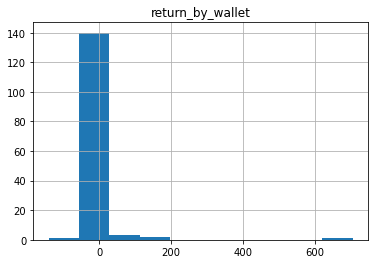

Number of wallets with POSITIVE returns: 121
Number of wallets with NEGATIVE returns: 26


In [20]:
df_wallet_return.hist('return_by_wallet')
plt.show()

print('Number of wallets with POSITIVE returns:', len(df_wallet_return[df_wallet_return['return_by_wallet']>0]))
print('Number of wallets with NEGATIVE returns:', len(df_wallet_return[df_wallet_return['return_by_wallet']<0]))

In [21]:
# a sanity check
# df_tx_reduce[df_tx_reduce['holders_address']=='0x50fc70265a5bf285d8644628efa5a4fb96d6b7cf']

In [22]:
df_wallet_return_merge = df_wallet_return[['holders_address','ending_value_in_USD','return_by_wallet']]
df_wallet_return_merge

,holders_address,ending_value_in_USD,return_by_wallet
1,0x0404d96d2583799bc73edb8d230aa037fc22b379,"312,418,887.48",1.54
114,0xc1ff7cea93d2324a76e1cb19c98d5e0a3a2b6b3f,"15,983,490.26",2.25
13,0x2434e7e28b2b139511bc2b6f31e14ee1e6e03b4f,"7,129,635.77",0.56
81,0x91dca37856240e5e1906222ec79278b16420dc92,"6,933,772.44",3.02
63,0x744727a6fc563f54fd0f6f0442c0bd1e212011f9,"5,043,270.01",0.55
...,...,...,...
138,0xf35a6bd6e0459a4b53a27862c51a2a7292b383d1,"-50,643,259.16",2.11
24,0x37d493e32ca5ef914389c8cb2e33e81805309d96,"-65,096,733.56",0.73
115,0xc2306a06993ebfb4a66b189c98fd1d5f03855349,"-114,234,000.00",7.22
3,0x08f14cfcc8f0b67bfac70d3f93623775577e0909,"-152,557,296.90",2.31


In [23]:
wallet_level_data2 = pd.merge(wallet_level_data2, df_wallet_return_merge, on ='holders_address', how ='inner')
wallet_level_data2.head()

,holders_address,USD_price_at_timestamp,inital_abs_value,initial_dt,initial_value,initial_value_in_USD,holding_period_days,ending_value_in_USD,return_by_wallet
0,0x00b9e69051e0b5787b8d2a9a0308e415294e6b8a,0.74,"279,251.22",2021-10-16 18:19:35,"-279,251.22","-207,564.59",48.00,"-2,018,986.29",8.73
1,0x0404d96d2583799bc73edb8d230aa037fc22b379,0.61,"3,000,000.00",2021-07-15 09:11:20,"3,000,000.00","1,833,634.38",141.00,"312,418,887.48",1.54
2,0x07445065963c2d563cd70ddf2aa49fc771e59a98,3.92,"1,770,000.00",2021-11-22 06:23:10,"-1,770,000.00","-6,943,437.70",11.00,"-12,797,100.00",0.84
3,0x08f14cfcc8f0b67bfac70d3f93623775577e0909,0.39,10.00,2021-07-07 08:58:09,-10.00,-3.88,149.00,"-152,557,296.90",2.31
4,0x187e3534f461d7c59a7d6899a983a5305b48f93f,0.76,"46,503.26",2021-10-22 10:05:03,"-46,503.26","-35,520.23",42.00,"-1,138,670.50",2.26


# Sanity Checks

In [24]:
print(df_tx.columns)

# Only pulls in transaction type: transfer.
print(f'\n\nThe type of transaction pulled:')
display(df_tx.value_counts(['tx_type']))

# Date Range, seems reasonable
print(f'\n\nThe first date of date range is:')
display(df_tx['date_time'].min())
print(f'\n\nThe last date of date range is:')
display(df_tx['date_time'].max())

# Any same to/from addresses?
print(f'\n\nWere there transactions where the tokens were transfer from one wallet to itself?')
display(df_tx.value_counts(df_tx['address_from']==df_tx['address_to']))
                       
# 18k transactions in line with Ethan's estimates.
print(f'\n\nThe total number of transactions in the dataset:')
print(f'Shape: {df_tx.shape}')


Index(['holders_address', 'holders_balance', 'holders_share', 'holders_tag',
       'transactionHash', 'timestamp', 'tx_type', 'address_from', 'address_to',
       'abs_value', 'USD_price_at_timestamp', 'uniq_transID', 'date_time',
       'value', 'value_in_USD'],
      dtype='object')


The type of transaction pulled:


tx_type 
transfer    12277
dtype: int64



The first date of date range is:


Timestamp('2020-08-11 23:08:29')



The last date of date range is:


Timestamp('2021-11-24 20:36:55')



Were there transactions where the tokens were transfer from one wallet to itself?


False    12277
dtype: int64



The total number of transactions in the dataset:
Shape: (12277, 15)


In [25]:
# The sum of the holders_share should be less than 100%
print(f'\n\nThe sum of the holders_share is:')
total_share = df_tx[['holders_address', 'holders_share']].groupby('holders_address').max().sort_values('holders_share', ascending=False)
display(total_share['holders_share'].sum())

# What is the sum of holders_share that are "Smart Contracts?"
print(f'\n\nThe sum of the holders_share tagged as "Smart Contracts" is:')
tagged_transactions = df_flat[df_flat['holders_tag'].notnull()]
smart_contracts = tagged_transactions[tagged_transactions['holders_tag'].str.contains('Smart Contract',regex=False)]
smart_contracts_share = smart_contracts[['holders_address', 'holders_share','holders_tag']].groupby('holders_address').max().sort_values('holders_share', ascending=False).sum()
display(smart_contracts_share['holders_share'].sum().round())

# What is the sum of holder_share that are Exchanges?
print(f'\n\nThe sum of the holders_share tagged as exchanges is:')
not_smart_contracts = tagged_transactions[~tagged_transactions['holders_tag'].str.contains('Smart Contract',regex=False)]
not_contracts_share = not_smart_contracts[['holders_address', 'holders_share','holders_tag']].groupby('holders_address').max().sort_values('holders_share', ascending=False).sum()
display(not_contracts_share['holders_share'].sum())

# The sum of the balance should be less than 100% of the total # of circulating tokens
print(f'\n\nThe sum of the holders_balance is:')
total_balance = df_tx[['holders_address', 'holders_balance']].groupby('holders_address').max().sort_values('holders_balance', ascending=False)
display(total_balance['holders_balance'].sum().round())


# The USD price at each date_time stamp
print(f'\n\nThe USD price at each date_time stamp:')
display(df_tx[['date_time', 'USD_price_at_timestamp']].sort_values('date_time'))




The sum of the holders_share is:


10.39



The sum of the holders_share tagged as "Smart Contracts" is:


73.0



The sum of the holders_share tagged as exchanges is:


13.71



The sum of the holders_balance is:


306246788.0



The USD price at each date_time stamp:


,date_time,USD_price_at_timestamp
4284,2020-08-11 23:08:29,0.05
6768,2020-08-13 20:43:14,0.04
1321,2020-08-14 15:15:04,0.06
1320,2020-08-14 15:20:29,0.06
1319,2020-08-14 15:33:14,0.06
...,...,...
16364,2021-11-24 20:31:33,7.37
5367,2021-11-24 20:34:00,7.37
5366,2021-11-24 20:34:37,7.37
16363,2021-11-24 20:35:18,7.37


## Daily SAND price, market cap, and trading volume

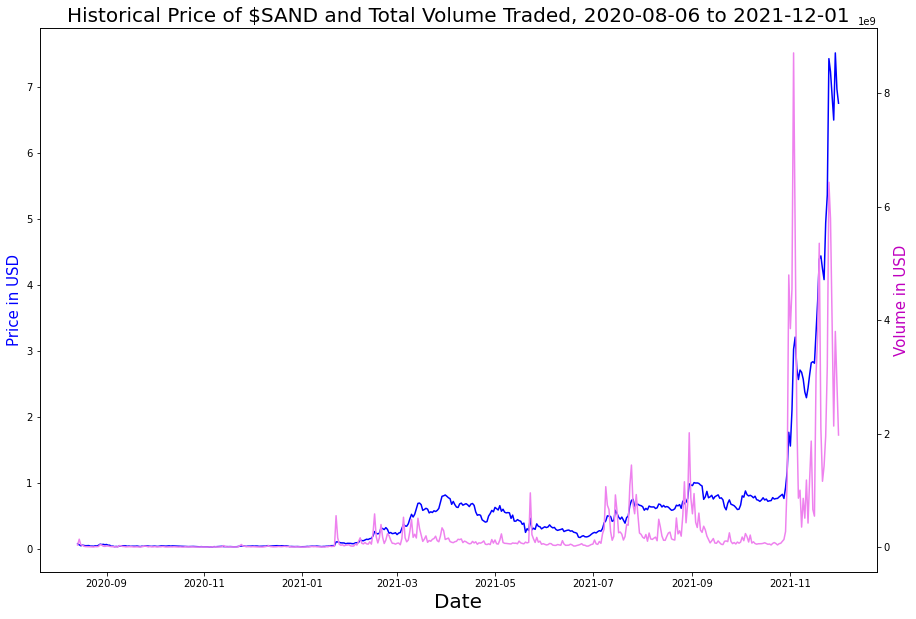

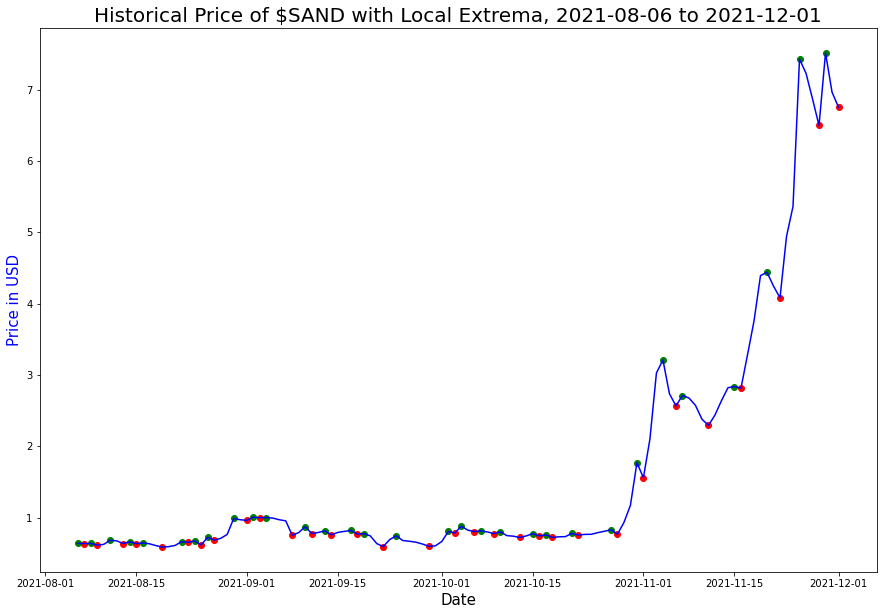

In [26]:
# Graph full time range of $SAND returns for COIN Gecko API from 2020-08-05 to now
# Set time range, then pull SAND returns, and lastly graph the dataset
time_range = si.set_timeframe('2020-8-5', '2021-12-1')
sand_info_df = si.get_sand_returns(time_range)
si.sand_price_volume_plot(sand_info_df)

# Graph more recent time range of $SAND returns with local max and min
time_range_m = si.set_timeframe('2021-8-5', '2021-12-1')
sand_info_m = si.get_sand_returns(time_range_m)
si.sand_mm_plot(sand_info_m)


In [27]:
# Shows the local min and max values in the $SAND price data
max_min_df = sand_info_df.loc[(sand_info_df['min'].notnull()) | (sand_info_df['max'].notnull())]
max_min_df.head()

,date,prices,market_caps,total_volumes,min,max
0,2020-08-14,0.08,0.00,"38,413,022.86",NaN,0.08
2,2020-08-16,0.05,0.00,"43,150,411.00",0.05,NaN
3,2020-08-17,0.06,"32,764,630.85","33,700,874.11",NaN,0.06
5,2020-08-19,0.05,"27,179,712.53","10,332,400.20",0.05,NaN
7,2020-08-21,0.05,"28,279,406.59","9,424,347.31",NaN,0.05


## Calculate SAND returns and alpha

In [28]:
# SANITY CHECK to see if the dates for the two df (wallet_level_data2 and sand_info_df) align

# From this check, it's evident that Coin Gecko does not have data on the $SAND price
# before 8/14/2021, which means we won't be able to pull the price data for any dates before then.

print("The minimum date in 'wallet_level_data2':\n", wallet_level_data2['initial_dt'].min(), "\n\n")
print("The minimum date in 'sand_info_df' that is pulled from coin gecko is:\n\n", sand_info_df.min())



The minimum date in 'wallet_level_data2':
 2020-08-11 23:08:29 


The minimum date in 'sand_info_df' that is pulled from coin gecko is:

 date             2020-08-14 00:00:00
prices                          0.03
market_caps                     0.00
total_volumes           2,094,053.43
min                             0.03
max                             0.04
dtype: object


In [29]:
# Calculating SAND returns and alpha

wallet_level_data2['sand_return'] = ending_sand_price/wallet_level_data2['USD_price_at_timestamp']-1
wallet_level_data2['wallet_alpha'] = wallet_level_data2['return_by_wallet'] - wallet_level_data2['sand_return']
wallet_level_data2

,holders_address,USD_price_at_timestamp,inital_abs_value,initial_dt,initial_value,initial_value_in_USD,holding_period_days,ending_value_in_USD,return_by_wallet,sand_return,wallet_alpha
0,0x00b9e69051e0b5787b8d2a9a0308e415294e6b8a,0.74,"279,251.22",2021-10-16 18:19:35,"-279,251.22","-207,564.59",48.00,"-2,018,986.29",8.73,8.73,0.00
1,0x0404d96d2583799bc73edb8d230aa037fc22b379,0.61,"3,000,000.00",2021-07-15 09:11:20,"3,000,000.00","1,833,634.38",141.00,"312,418,887.48",1.54,10.83,-9.29
2,0x07445065963c2d563cd70ddf2aa49fc771e59a98,3.92,"1,770,000.00",2021-11-22 06:23:10,"-1,770,000.00","-6,943,437.70",11.00,"-12,797,100.00",0.84,0.84,-0.00
3,0x08f14cfcc8f0b67bfac70d3f93623775577e0909,0.39,10.00,2021-07-07 08:58:09,-10.00,-3.88,149.00,"-152,557,296.90",2.31,17.66,-15.35
4,0x187e3534f461d7c59a7d6899a983a5305b48f93f,0.76,"46,503.26",2021-10-22 10:05:03,"-46,503.26","-35,520.23",42.00,"-1,138,670.50",2.26,8.47,-6.21
...,...,...,...,...,...,...,...,...,...,...,...
142,0xfb36f1f496dfb78f4d84f65a8c58a6475329be76,0.11,"2,083,646.65",2021-01-21 11:24:43,"-2,083,646.65","-233,219.89",316.00,"-5,659,089.02",10.15,63.59,-53.44
143,0xfd80c78b3f755a25a7698aa335b2b6a8ca230e84,0.81,"1,000.00",2021-10-06 03:34:00,"-1,000.00",-808.77,58.00,"-1,229,100.00",8.02,7.94,0.08
144,0xfed694dc2ce345dc23a5a915cdb5d55b258351c9,0.81,47.00,2021-10-05 06:26:03,-47.00,-38.08,59.00,"-7,577,079.44",7.88,7.92,-0.05
145,0xff0cb0351a356ad16987e5809a8daaaf34f5adbe,0.27,"411,646.43",2021-07-05 04:16:58,"-411,646.43","-111,457.26",151.00,"-6,177,172.26",9.01,25.70,-16.69


## Calculate both annualized wallet and SAND returns

In [30]:
# Calculate wallet returns
wallet_level_data2['annualized_wallet_returns'] = (1+wallet_level_data2['return_by_wallet'])\
                                                    **(365/wallet_level_data2['holding_period_days'])-1

# Calculate SAND returns
wallet_level_data2['annualized_sand_returns'] = (1+wallet_level_data2['sand_return'])\
                                                    **(365/wallet_level_data2['holding_period_days'])-1

In [31]:
wallet_level_data2

,holders_address,USD_price_at_timestamp,inital_abs_value,initial_dt,initial_value,initial_value_in_USD,holding_period_days,ending_value_in_USD,return_by_wallet,sand_return,wallet_alpha,annualized_wallet_returns,annualized_sand_returns
0,0x00b9e69051e0b5787b8d2a9a0308e415294e6b8a,0.74,"279,251.22",2021-10-16 18:19:35,"-279,251.22","-207,564.59",48.00,"-2,018,986.29",8.73,8.73,0.00,"32,566,068.00","32,566,068.00"
1,0x0404d96d2583799bc73edb8d230aa037fc22b379,0.61,"3,000,000.00",2021-07-15 09:11:20,"3,000,000.00","1,833,634.38",141.00,"312,418,887.48",1.54,10.83,-9.29,10.20,598.08
2,0x07445065963c2d563cd70ddf2aa49fc771e59a98,3.92,"1,770,000.00",2021-11-22 06:23:10,"-1,770,000.00","-6,943,437.70",11.00,"-12,797,100.00",0.84,0.84,-0.00,"647,144,314.36","647,144,314.36"
3,0x08f14cfcc8f0b67bfac70d3f93623775577e0909,0.39,10.00,2021-07-07 08:58:09,-10.00,-3.88,149.00,"-152,557,296.90",2.31,17.66,-15.35,17.76,"1,296.28"
4,0x187e3534f461d7c59a7d6899a983a5305b48f93f,0.76,"46,503.26",2021-10-22 10:05:03,"-46,503.26","-35,520.23",42.00,"-1,138,670.50",2.26,8.47,-6.21,"28,472.96","304,209,775.70"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
142,0xfb36f1f496dfb78f4d84f65a8c58a6475329be76,0.11,"2,083,646.65",2021-01-21 11:24:43,"-2,083,646.65","-233,219.89",316.00,"-5,659,089.02",10.15,63.59,-53.44,15.21,122.28
143,0xfd80c78b3f755a25a7698aa335b2b6a8ca230e84,0.81,"1,000.00",2021-10-06 03:34:00,"-1,000.00",-808.77,58.00,"-1,229,100.00",8.02,7.94,0.08,"1,024,793.33","969,832.83"
144,0xfed694dc2ce345dc23a5a915cdb5d55b258351c9,0.81,47.00,2021-10-05 06:26:03,-47.00,-38.08,59.00,"-7,577,079.44",7.88,7.92,-0.05,"734,593.56","759,322.76"
145,0xff0cb0351a356ad16987e5809a8daaaf34f5adbe,0.27,"411,646.43",2021-07-05 04:16:58,"-411,646.43","-111,457.26",151.00,"-6,177,172.26",9.01,25.70,-16.69,261.02,"2,806.33"


## Calculate wallet beta

In [32]:
wallet_level_data2['wallet_beta'] = ending_sand_price/wallet_level_data2['USD_price_at_timestamp']
wallet_level_data2

,holders_address,USD_price_at_timestamp,inital_abs_value,initial_dt,initial_value,initial_value_in_USD,holding_period_days,ending_value_in_USD,return_by_wallet,sand_return,wallet_alpha,annualized_wallet_returns,annualized_sand_returns,wallet_beta
0,0x00b9e69051e0b5787b8d2a9a0308e415294e6b8a,0.74,"279,251.22",2021-10-16 18:19:35,"-279,251.22","-207,564.59",48.00,"-2,018,986.29",8.73,8.73,0.00,"32,566,068.00","32,566,068.00",9.73
1,0x0404d96d2583799bc73edb8d230aa037fc22b379,0.61,"3,000,000.00",2021-07-15 09:11:20,"3,000,000.00","1,833,634.38",141.00,"312,418,887.48",1.54,10.83,-9.29,10.20,598.08,11.83
2,0x07445065963c2d563cd70ddf2aa49fc771e59a98,3.92,"1,770,000.00",2021-11-22 06:23:10,"-1,770,000.00","-6,943,437.70",11.00,"-12,797,100.00",0.84,0.84,-0.00,"647,144,314.36","647,144,314.36",1.84
3,0x08f14cfcc8f0b67bfac70d3f93623775577e0909,0.39,10.00,2021-07-07 08:58:09,-10.00,-3.88,149.00,"-152,557,296.90",2.31,17.66,-15.35,17.76,"1,296.28",18.66
4,0x187e3534f461d7c59a7d6899a983a5305b48f93f,0.76,"46,503.26",2021-10-22 10:05:03,"-46,503.26","-35,520.23",42.00,"-1,138,670.50",2.26,8.47,-6.21,"28,472.96","304,209,775.70",9.47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142,0xfb36f1f496dfb78f4d84f65a8c58a6475329be76,0.11,"2,083,646.65",2021-01-21 11:24:43,"-2,083,646.65","-233,219.89",316.00,"-5,659,089.02",10.15,63.59,-53.44,15.21,122.28,64.59
143,0xfd80c78b3f755a25a7698aa335b2b6a8ca230e84,0.81,"1,000.00",2021-10-06 03:34:00,"-1,000.00",-808.77,58.00,"-1,229,100.00",8.02,7.94,0.08,"1,024,793.33","969,832.83",8.94
144,0xfed694dc2ce345dc23a5a915cdb5d55b258351c9,0.81,47.00,2021-10-05 06:26:03,-47.00,-38.08,59.00,"-7,577,079.44",7.88,7.92,-0.05,"734,593.56","759,322.76",8.92
145,0xff0cb0351a356ad16987e5809a8daaaf34f5adbe,0.27,"411,646.43",2021-07-05 04:16:58,"-411,646.43","-111,457.26",151.00,"-6,177,172.26",9.01,25.70,-16.69,261.02,"2,806.33",26.70


## Calculating volatility

In [33]:
# SANITY CHECK to see if the dates for the two df (wallet_level_data2 and sand_info_df) align

# From this check, it's evident that Coin Gecko does not have data on the $SAND price
# before 8/14/2021, which means we won't be able to pull the price data for any dates before then.

print("The minimum date in 'wallet_level_data2':\n", wallet_level_data2['initial_dt'].min(), "\n\n")
print("The minimum date in 'sand_info_df' that is pulled from coin gecko is:\n\n", sand_info_df.min())


The minimum date in 'wallet_level_data2':
 2020-08-11 23:08:29 


The minimum date in 'sand_info_df' that is pulled from coin gecko is:

 date             2020-08-14 00:00:00
prices                          0.03
market_caps                     0.00
total_volumes           2,094,053.43
min                             0.03
max                             0.04
dtype: object


In [42]:
volatility_df = []

for i in list(wallet_level_data2['initial_dt']):
    
    # Convert initial_dt date/time to a standard string format
    start_date = si.standard_date(i)
    
    # Get index corresponding with the specified start_date
    index = si.get_index(start_date, sand_info_df)

    # Filter the sand_info_df to have only prices data over the specified time frame
    get_volatility = si.filter_df(index, sand_info_df)

    # Calculate the volatility for SAND over this timeframe
    volatility = si.sand_volatility(get_volatility)
    
    # Append to the volatility_df list
    volatility_df.append(volatility)

wallet_level_data2['sand_volatility'] = pd.DataFrame(volatility_df)


In [43]:
wallet_level_data2

,holders_address,USD_price_at_timestamp,inital_abs_value,initial_dt,initial_value,initial_value_in_USD,holding_period_days,ending_value_in_USD,return_by_wallet,sand_return,wallet_alpha,annualized_wallet_returns,annualized_sand_returns,wallet_beta,sand_volatility
0,0x00b9e69051e0b5787b8d2a9a0308e415294e6b8a,0.74,"279,251.22",2021-10-16 18:19:35,"-279,251.22","-207,564.59",48.00,"-2,018,986.29",8.73,8.73,0.00,"32,566,068.00","32,566,068.00",9.73,2.01
1,0x0404d96d2583799bc73edb8d230aa037fc22b379,0.61,"3,000,000.00",2021-07-15 09:11:20,"3,000,000.00","1,833,634.38",141.00,"312,418,887.48",1.54,10.83,-9.29,10.20,598.08,11.83,1.59
2,0x07445065963c2d563cd70ddf2aa49fc771e59a98,3.92,"1,770,000.00",2021-11-22 06:23:10,"-1,770,000.00","-6,943,437.70",11.00,"-12,797,100.00",0.84,0.84,-0.00,"647,144,314.36","647,144,314.36",1.84,2.21
3,0x08f14cfcc8f0b67bfac70d3f93623775577e0909,0.39,10.00,2021-07-07 08:58:09,-10.00,-3.88,149.00,"-152,557,296.90",2.31,17.66,-15.35,17.76,"1,296.28",18.66,1.65
4,0x187e3534f461d7c59a7d6899a983a5305b48f93f,0.76,"46,503.26",2021-10-22 10:05:03,"-46,503.26","-35,520.23",42.00,"-1,138,670.50",2.26,8.47,-6.21,"28,472.96","304,209,775.70",9.47,2.13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142,0xfb36f1f496dfb78f4d84f65a8c58a6475329be76,0.11,"2,083,646.65",2021-01-21 11:24:43,"-2,083,646.65","-233,219.89",316.00,"-5,659,089.02",10.15,63.59,-53.44,15.21,122.28,64.59,1.84
143,0xfd80c78b3f755a25a7698aa335b2b6a8ca230e84,0.81,"1,000.00",2021-10-06 03:34:00,"-1,000.00",-808.77,58.00,"-1,229,100.00",8.02,7.94,0.08,"1,024,793.33","969,832.83",8.94,1.86
144,0xfed694dc2ce345dc23a5a915cdb5d55b258351c9,0.81,47.00,2021-10-05 06:26:03,-47.00,-38.08,59.00,"-7,577,079.44",7.88,7.92,-0.05,"734,593.56","759,322.76",8.92,1.85
145,0xff0cb0351a356ad16987e5809a8daaaf34f5adbe,0.27,"411,646.43",2021-07-05 04:16:58,"-411,646.43","-111,457.26",151.00,"-6,177,172.26",9.01,25.70,-16.69,261.02,"2,806.33",26.70,1.65


## Data Analysis

count    147.00
mean     -10.06
std       62.00
min     -163.72
25%       -8.15
50%       -1.31
75%       -0.00
max      579.55
Name: wallet_alpha, dtype: float64

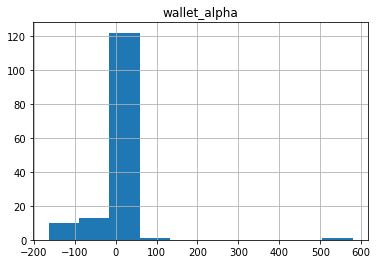

Number of wallets with POSITIVE alpha: 22
Number of wallets with NEGATIVE alpha: 111


In [38]:
# Graph histogram of the wallet alpha spread
display(wallet_level_data2['wallet_alpha'].describe())

wallet_level_data2.hist('wallet_alpha')
plt.show()

print('Number of wallets with POSITIVE alpha:', len(wallet_level_data2[wallet_level_data2['wallet_alpha']>0]))
print('Number of wallets with NEGATIVE alpha:', len(wallet_level_data2[wallet_level_data2['wallet_alpha']<0]))